In [67]:
import os
import torch
import timm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split,Dataset,Subset
from torch import nn, optim
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix, classification_report
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
import numpy as np
import pandas as pd
import random
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from torchvision.transforms import Compose, ToTensor, Normalize
device = torch.device("mps") # For Apple M1/M2

import warnings
warnings.filterwarnings('ignore')


In [68]:
# Set seeds
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Preprocessing

In [69]:
# training transformations
transform_train = transforms.Compose([
    transforms.RandomRotation(degrees = 20),
    transforms.RandomHorizontalFlip(p = 0.30),
    transforms.RandomVerticalFlip(p = 0.30),

    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images

])
# testing transformations
transform_test = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images

])

# Load the dataset
train_dataset = datasets.ImageFolder(root='./data/train', transform=transform_train)
full_val_dataset = datasets.ImageFolder(root='./data/test',transform=transform_test)


In [70]:
# examples to remove
num_to_remove = 699  

# Convert to NumPy array for efficient computation
targets_np = np.array(train_dataset.targets)

# Find indices of class 0
class_0_indices = np.where(targets_np == 0)[0]

# Randomly select indices to remove
indices_to_remove = np.random.choice(class_0_indices, size=num_to_remove, replace=False)

# Use set operations to find the remaining indices
remaining_indices = np.setdiff1d(np.arange(len(targets_np)), indices_to_remove)

# Create a new dataset from the remaining indices
balanced_train_dataset = Subset(train_dataset, remaining_indices)

# Now, balanced_train_dataset excludes the randomly removed class 0 examples


In [71]:

# Ensure balanced split for validation and test sets
def balanced_split(dataset, test_size=0.3):
    labels = np.array(dataset.targets)
    # Find indices for each class
    indices_class0 = np.where(labels == 0)[0]
    indices_class1 = np.where(labels == 1)[0]

    # Perform a split for each class
    indices_class0_train, indices_class0_test = train_test_split(indices_class0, test_size=test_size, random_state=42)
    indices_class1_train, indices_class1_test = train_test_split(indices_class1, test_size=test_size, random_state=42)

    # Combine the indices back to get balanced datasets
    train_indices = np.concatenate((indices_class0_train, indices_class1_train))
    test_indices = np.concatenate((indices_class0_test, indices_class1_test))

    # Shuffle the indices
    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)

    # Create subsets for train and test
    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)

    return train_subset, test_subset

# Split full_val_dataset into balanced validation and test datasets
val_dataset, test_dataset = balanced_split(full_val_dataset, test_size=0.3)

# DataLoaders
train_loader = DataLoader(balanced_train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)


# EDA

In [72]:
def print_class_counts_for_subset(original_dataset, subset):
    # Retrieve labels for the subset
    subset_labels = [original_dataset.targets[i] for i in subset.indices]

    # Count each class in the subset
    class_counts = {}
    for label in subset_labels:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1

    # Print class counts
    print("Class counts in the balanced subset:")
    for label, count in class_counts.items():
        class_name = original_dataset.classes[label]
        print(f"{class_name}: {count}")

print("********Train dataset********")
print_class_counts_for_subset(train_dataset, balanced_train_dataset)
print("********Val dataset********")
print_class_counts_for_subset(full_val_dataset, val_dataset)
print("********Test dataset********")
print_class_counts_for_subset(full_val_dataset, test_dataset)


********Train dataset********
Class counts in the balanced subset:
Benign: 5590
Malignant: 5590
********Val dataset********
Class counts in the balanced subset:
Malignant: 700
Benign: 700
********Test dataset********
Class counts in the balanced subset:
Malignant: 300
Benign: 300


In [73]:
def texture_analysis(image):
    gray_image = rgb2gray(image) * 255
    gray_image = gray_image.astype('uint8')
    glcm = graycomatrix(gray_image, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    features = {
        'contrast': graycoprops(glcm, 'contrast')[0, 0],
        'dissimilarity': graycoprops(glcm, 'dissimilarity')[0, 0],
        'homogeneity': graycoprops(glcm, 'homogeneity')[0, 0],
        'energy': graycoprops(glcm, 'energy')[0, 0],
        'correlation': graycoprops(glcm, 'correlation')[0, 0]
    }
    return features


# Initialize containers for texture features by class
texture_features_benign = {'contrast': [], 'dissimilarity': [], 'homogeneity': [], 'energy': [], 'correlation': []}
texture_features_malignant = {'contrast': [], 'dissimilarity': [], 'homogeneity': [], 'energy': [], 'correlation': []}
# Initialize lists to store intensities
benign_intensities = []
malignant_intensities = []

# Process each batch from DataLoader
for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    # Calculate average intensity for each image in the batch
    average_intensities = images.mean(dim=[1, 2, 3]).cpu().numpy()

    # Convert PyTorch tensors to NumPy arrays and rescale to [0, 255]
    images_np = images.cpu().numpy()
    images_np = np.transpose(images_np, (0, 2, 3, 1))  # Change from (N, C, H, W) to (N, H, W, C)
    images_np = (images_np * 255).astype(np.uint8)  # Scale and cast to uint8
    
    for i, image_np in enumerate(images_np):
        label = labels[i].item()
        features = texture_analysis(image_np)
        average_intensity = average_intensities[i]  # Get the average intensity for this specific image
        
        # Append intensity based on label
        if label == 0:  # Benign
            benign_intensities.append(average_intensity)  # Append individual intensity value
            for key in texture_features_benign:
                texture_features_benign[key].append(features[key])
        else:  # Malignant
            malignant_intensities.append(average_intensity)  # Append individual intensity value
            for key in texture_features_malignant:
                texture_features_malignant[key].append(features[key])

# Calculate and print mean intensities
mean_benign_intensity = np.mean(benign_intensities)
mean_malignant_intensity = np.mean(malignant_intensities)
print(f"Mean Benign Intensity: {mean_benign_intensity}")
print(f"Mean Malignant Intensity: {mean_malignant_intensity}")



Mean Benign Intensity: 0.7477799654006958
Mean Malignant Intensity: 0.27148598432540894


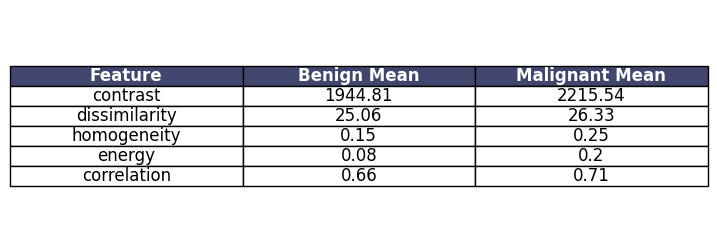

In [74]:
# Initialize arrays to hold mean values for table
features = list(texture_features_benign.keys())
benign_means = [np.mean(texture_features_benign[feature]) for feature in features]
malignant_means = [np.mean(texture_features_malignant[feature]) for feature in features]

# Prepare data for table
data = []
for i, feature in enumerate(features):
    data.append([feature, round(benign_means[i], 2), round(malignant_means[i], 2)])

# Create figure and axis
fig, ax = plt.subplots(figsize=(5, 3)) 
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(cellText=data, colLabels=['Feature', 'Benign Mean', 'Malignant Mean'], loc='center', cellLoc='center')

# Adjust table
table.auto_set_font_size(False)
table.set_fontsize(12)  
table.scale(1.8, 1.2)  
# Change the color of the first row (header)
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Check if this is the first row (header)
        cell.set_facecolor('#40466e') 
        cell.set_text_props(weight='bold', color='white') 

plt.show()

# Model & Training

In [75]:
# Load a pre-trained DINO ViT-Base model and modify it for binary classification
model = timm.create_model('vit_base_patch16_224.dino', pretrained=True, num_classes=1)
# Replace the classifier head with a new one for binary classification
model.head = nn.Linear(model.head.in_features, 1)

# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier
for param in model.head.parameters():
    param.requires_grad = True


# Unfreeze the last 8 transformer blocks
for block in model.blocks[-8:]:
    for param in block.parameters():
        param.requires_grad = True

# Defining the loss, optimizer, and annealer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)


In [76]:
model = nn.DataParallel(model).to(device)
patience = 7  # How many epochs to wait after last time validation loss improved.
best_val_loss = float('inf')  # Initialize best loss to infinity
trigger_times = 0  # How many times the early stopping condition has been met
device

device(type='mps')

In [6]:
scaler = GradScaler()
num_epochs = 25

# Lists to track progress
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()  # Ensure labels are float

        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        #loss.backward()
        #optimizer.step()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    correct_preds = 0
    total_samples = 0
    torch.cuda.empty_cache()  # Clear cache

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        # Apply sigmoid to convert logits to probabilities
            predictions = torch.sigmoid(outputs) > 0.5
            correct_preds += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    val_accuracy = correct_preds / total_samples
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]*100:.2f}%')

    scheduler.step()
    torch.cuda.empty_cache()  # Clear cache

    # Early stopping check
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        print(f"Early stopping counter: {trigger_times} of {patience}")

        if trigger_times >= patience:
            print("Early stopping activated. Training stopped.")
            break

Epoch 1, Training Loss: 0.2797, Training Accuracy: 88.60%, Validation Loss: 0.2296, Validation Accuracy: 90.35%
Epoch 2, Training Loss: 0.1865, Training Accuracy: 92.50%, Validation Loss: 0.1523, Validation Accuracy: 93.85%
Epoch 3, Training Loss: 0.1535, Training Accuracy: 93.79%, Validation Loss: 0.1544, Validation Accuracy: 94.05%
Early stopping counter: 1 of 10
Epoch 4, Training Loss: 0.1232, Training Accuracy: 95.24%, Validation Loss: 0.1321, Validation Accuracy: 95.25%
Epoch 5, Training Loss: 0.1069, Training Accuracy: 95.79%, Validation Loss: 0.1667, Validation Accuracy: 93.70%
Early stopping counter: 1 of 10
Epoch 6, Training Loss: 0.0438, Training Accuracy: 98.42%, Validation Loss: 0.1209, Validation Accuracy: 95.35%
Epoch 7, Training Loss: 0.0237, Training Accuracy: 99.09%, Validation Loss: 0.1360, Validation Accuracy: 95.90%
Early stopping counter: 1 of 10
Epoch 8, Training Loss: 0.0173, Training Accuracy: 99.36%, Validation Loss: 0.1730, Validation Accuracy: 95.45%
Early st

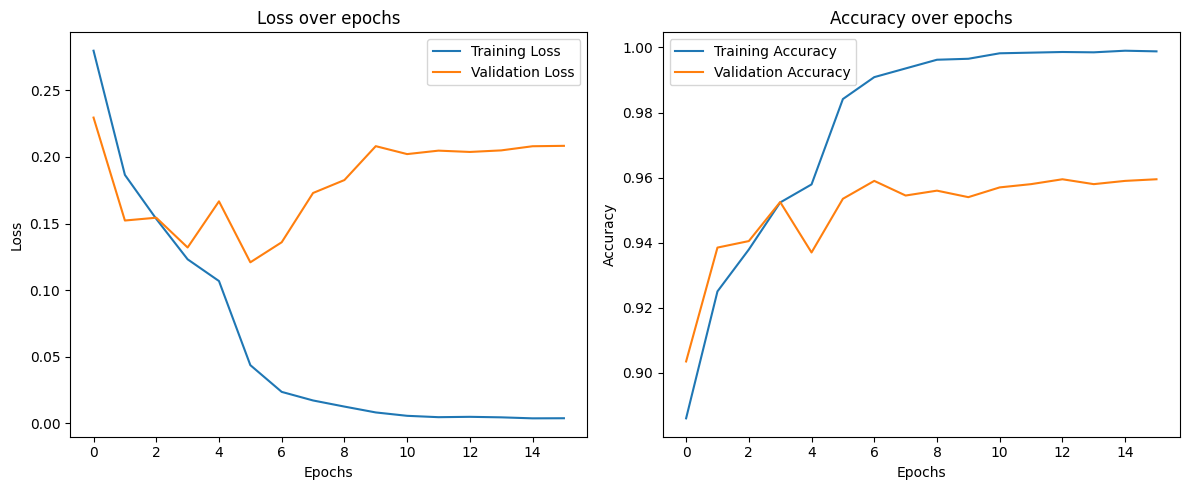

In [7]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Model Testing

In [ ]:

# Load the best model for testing
model.load_state_dict(torch.load('best_model.pth'))

# Testing
predicted_labels = []
true_labels = []
# Initialize lists to store intensity values
benign_intensities = []
malignant_intensities = []

# To store samples
sample_images = []
sample_preds = []
sample_trues = []
sample_intensities=[]
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze()

        # Apply sigmoid to convert logits to probabilities
        probs = torch.sigmoid(outputs.squeeze())

        # Convert probabilities to binary predictions
        preds = (probs > 0.5).long()

        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        # Calculate average intensity for each image
        # Since images are normalized, we calculate the mean across all color channels
        image_intensities = images.mean(dim=[1, 2, 3]).cpu().numpy()

                # Collect samples for visualization
        if len(sample_images) < 10:  # Let's collect 10 samples
            sample_images.extend(images.cpu().numpy())
            sample_preds.extend(preds.cpu().numpy())
            sample_trues.extend(labels.cpu().numpy())
            sample_intensities.extend(image_intensities[:10 - len(sample_images)])  # Adjust the number to collect only up to 10 samples


        for i, pred in enumerate(preds):
            if pred == 0:  # Benign
                benign_intensities.append(image_intensities[i])
            else:  # Malignant
                malignant_intensities.append(image_intensities[i])


# Convert lists to numpy arrays for use with scikit-learn's metrics
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)
# Convert lists to numpy arrays
benign_intensities = np.array(benign_intensities)
malignant_intensities = np.array(malignant_intensities)


# Results

In [78]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
report = classification_report(true_labels, predicted_labels)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall (Sensitivity): {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")
print(report)

Test Accuracy: 95.17%
Precision: 96.89%
Recall (Sensitivity): 93.33%
F1 Score: 95.08%
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       300
           1       0.97      0.93      0.95       300

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



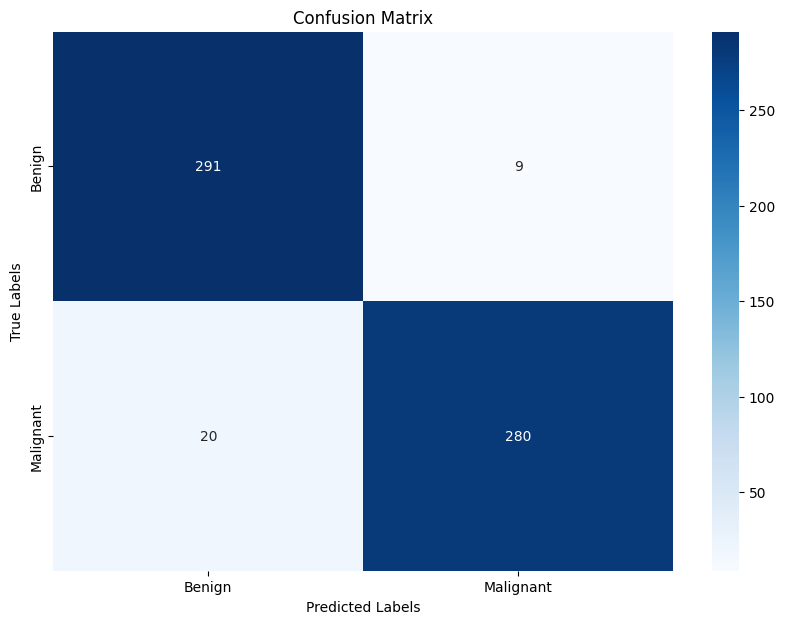

In [79]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

labels = ['Benign', 'Malignant']

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



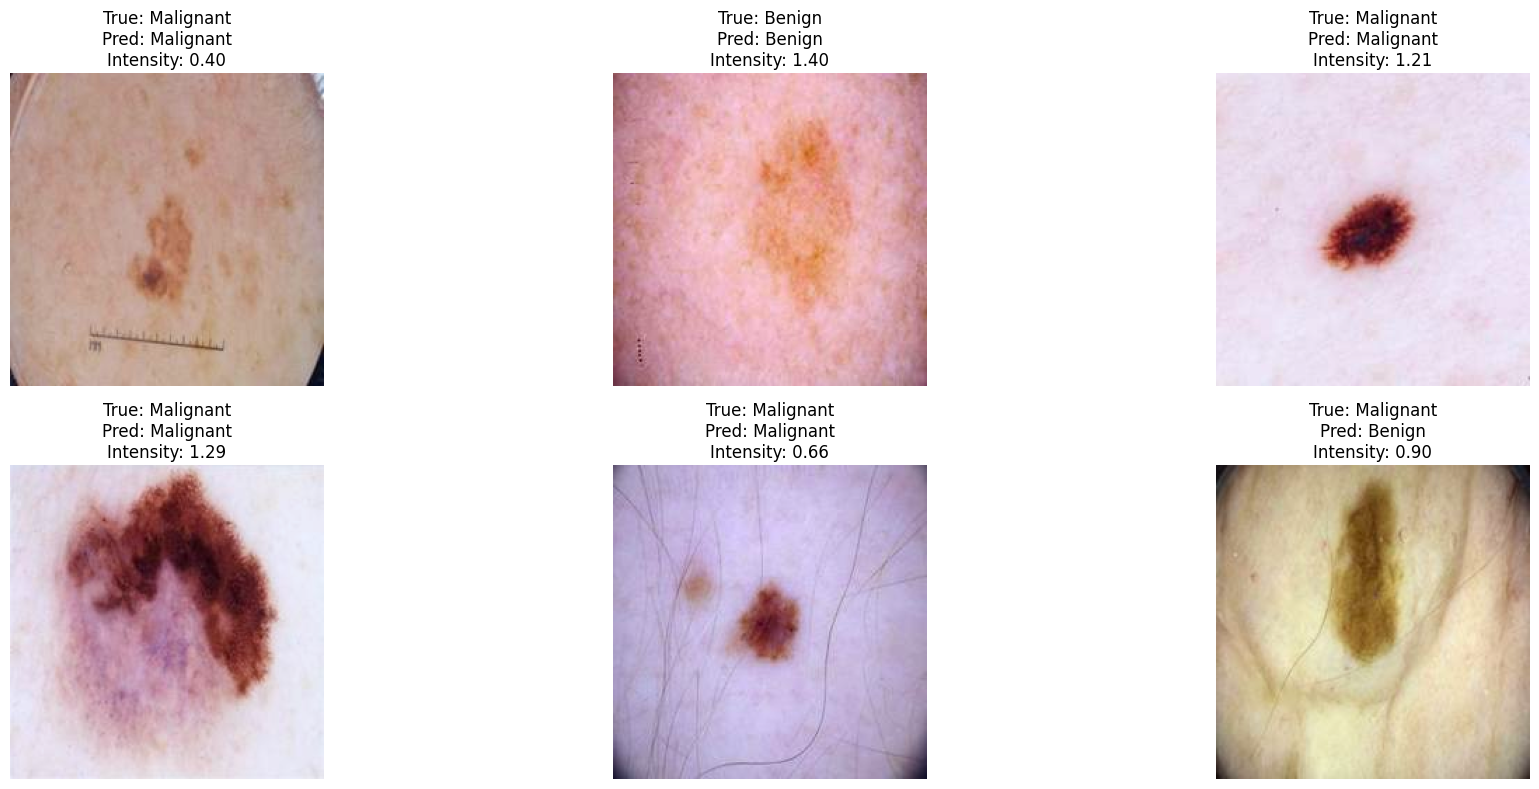

In [95]:
label_names = {0: "Benign", 1: "Malignant"}


# Visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 8))
for i, ax in enumerate(axes.flatten()):
    if i >= 6:  # Check if there are fewer than 6 samples
        break
    img = np.transpose(sample_images[i], (1, 2, 0))  # Convert image to [H,W,C] from [C,H,W]
    img = (img - img.min()) / (img.max() - img.min())  # Min-Max normalization for plotting
    ax.imshow(img)
    true_label_name = label_names[sample_trues[i]]
    pred_label_name = label_names[sample_preds[i]]
    intensity_score = sample_intensities[i]
    ax.set_title(f"True: {true_label_name}\nPred: {pred_label_name}\nIntensity: {intensity_score:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()


# Segmentation

Object 1: Area = 6.0 pixels
Object 2: Area = 2.0 pixels
Object 3: Area = 1042.0 pixels
Object 4: Area = 1.0 pixels
Object 5: Area = 2.0 pixels


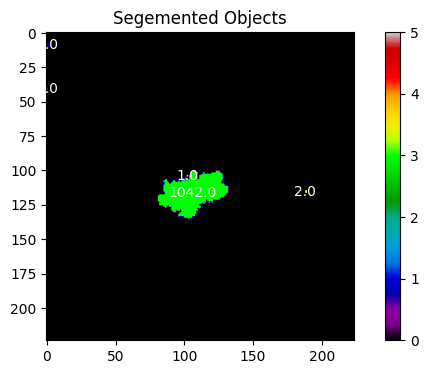

Object 1: Area = 5450.0 pixels
Object 2: Area = 1.0 pixels
Object 3: Area = 1.0 pixels
Object 4: Area = 1.0 pixels
Object 5: Area = 2.0 pixels
Object 6: Area = 2.0 pixels
Object 7: Area = 3.0 pixels
Object 8: Area = 2.0 pixels
Object 9: Area = 4.0 pixels
Object 10: Area = 7.0 pixels
Object 11: Area = 4.0 pixels
Object 12: Area = 1.0 pixels
Object 13: Area = 1.0 pixels
Object 14: Area = 5.0 pixels
Object 15: Area = 1.0 pixels
Object 16: Area = 3.0 pixels
Object 17: Area = 1.0 pixels
Object 18: Area = 4.0 pixels
Object 19: Area = 3.0 pixels
Object 20: Area = 1.0 pixels


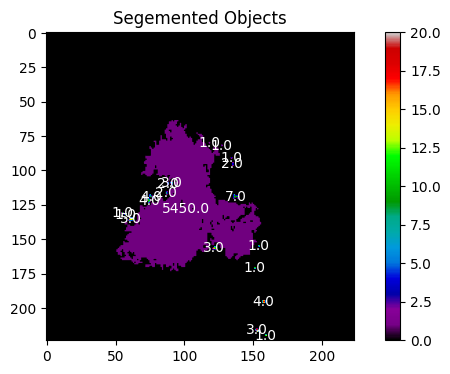

Object 1: Area = 5960.0 pixels
Object 2: Area = 15.0 pixels
Object 3: Area = 3.0 pixels
Object 4: Area = 1.0 pixels
Object 5: Area = 1.0 pixels
Object 6: Area = 1.0 pixels
Object 7: Area = 2.0 pixels
Object 8: Area = 3.0 pixels
Object 9: Area = 2.0 pixels
Object 10: Area = 55.0 pixels


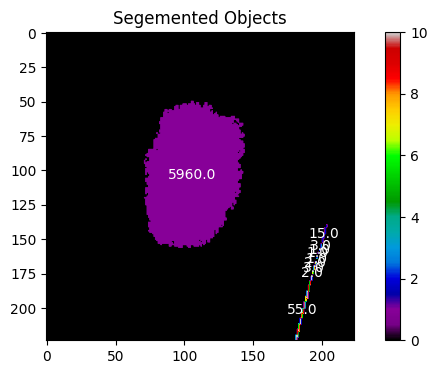

Object 1: Area = 6350.0 pixels
Object 2: Area = 5.0 pixels
Object 3: Area = 5.0 pixels
Object 4: Area = 15.0 pixels
Object 5: Area = 1.0 pixels
Object 6: Area = 1.0 pixels


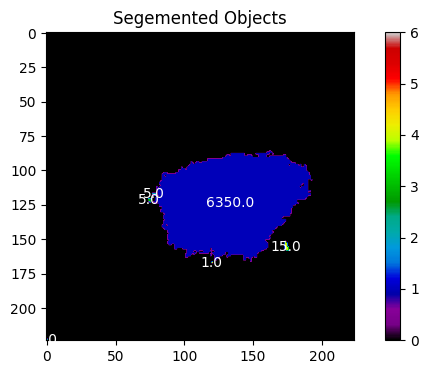

Object 1: Area = 17190.0 pixels
Object 2: Area = 1.0 pixels
Object 3: Area = 1.0 pixels
Object 4: Area = 4.0 pixels
Object 5: Area = 1.0 pixels
Object 6: Area = 4.0 pixels
Object 7: Area = 1.0 pixels
Object 8: Area = 6.0 pixels
Object 9: Area = 2.0 pixels
Object 10: Area = 2.0 pixels
Object 11: Area = 1.0 pixels
Object 12: Area = 5.0 pixels
Object 13: Area = 1.0 pixels
Object 14: Area = 3.0 pixels
Object 15: Area = 3.0 pixels
Object 16: Area = 1.0 pixels
Object 17: Area = 2.0 pixels
Object 18: Area = 1.0 pixels
Object 19: Area = 7.0 pixels
Object 20: Area = 2.0 pixels
Object 21: Area = 2.0 pixels
Object 22: Area = 2.0 pixels
Object 23: Area = 2.0 pixels
Object 24: Area = 1.0 pixels
Object 25: Area = 2.0 pixels
Object 26: Area = 1.0 pixels
Object 27: Area = 1.0 pixels
Object 28: Area = 1.0 pixels
Object 29: Area = 2.0 pixels
Object 30: Area = 3.0 pixels
Object 31: Area = 1.0 pixels
Object 32: Area = 1.0 pixels
Object 33: Area = 1.0 pixels
Object 34: Area = 1.0 pixels
Object 35: Area = 2

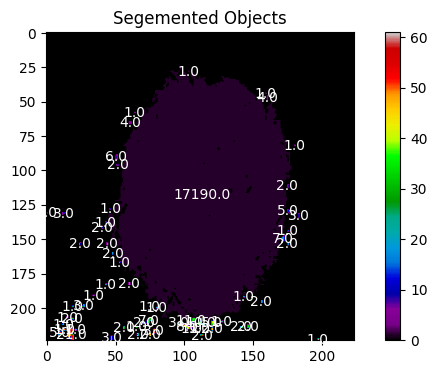

Object 1: Area = 3.0 pixels
Object 2: Area = 2.0 pixels
Object 3: Area = 638.0 pixels
Object 4: Area = 35.0 pixels
Object 5: Area = 4.0 pixels
Object 6: Area = 26.0 pixels
Object 7: Area = 3.0 pixels
Object 8: Area = 1.0 pixels
Object 9: Area = 8.0 pixels
Object 10: Area = 2.0 pixels
Object 11: Area = 1.0 pixels
Object 12: Area = 1.0 pixels
Object 13: Area = 3.0 pixels
Object 14: Area = 5.0 pixels
Object 15: Area = 4.0 pixels
Object 16: Area = 1.0 pixels
Object 17: Area = 2178.0 pixels
Object 18: Area = 1.0 pixels
Object 19: Area = 4.0 pixels
Object 20: Area = 2.0 pixels
Object 21: Area = 3.0 pixels
Object 22: Area = 2.0 pixels
Object 23: Area = 592.0 pixels
Object 24: Area = 2.0 pixels
Object 25: Area = 4.0 pixels
Object 26: Area = 401.0 pixels
Object 27: Area = 3.0 pixels
Object 28: Area = 1.0 pixels
Object 29: Area = 1.0 pixels
Object 30: Area = 139.0 pixels
Object 31: Area = 1.0 pixels
Object 32: Area = 4.0 pixels
Object 33: Area = 2.0 pixels
Object 34: Area = 3.0 pixels
Object 35:

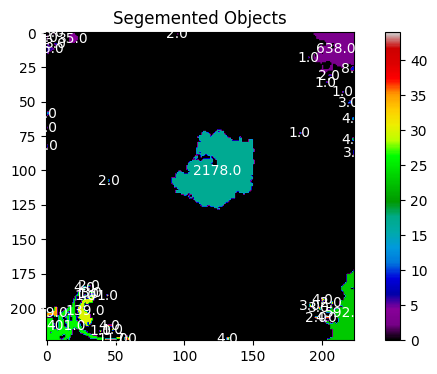

Object 1: Area = 19359.0 pixels
Object 2: Area = 5.0 pixels
Object 3: Area = 514.0 pixels
Object 4: Area = 20.0 pixels
Object 5: Area = 2.0 pixels
Object 6: Area = 8.0 pixels
Object 7: Area = 2.0 pixels
Object 8: Area = 1.0 pixels
Object 9: Area = 141.0 pixels
Object 10: Area = 2.0 pixels
Object 11: Area = 1.0 pixels
Object 12: Area = 9.0 pixels
Object 13: Area = 2.0 pixels
Object 14: Area = 1.0 pixels
Object 15: Area = 4.0 pixels
Object 16: Area = 1.0 pixels
Object 17: Area = 18.0 pixels
Object 18: Area = 1.0 pixels
Object 19: Area = 10.0 pixels
Object 20: Area = 1.0 pixels


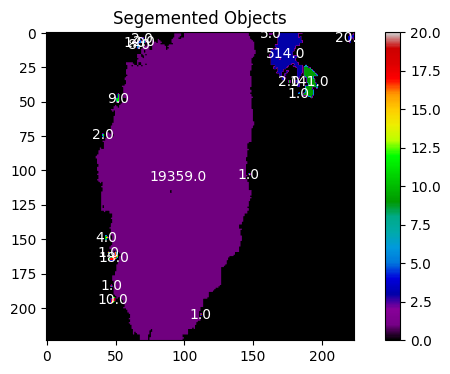

Object 1: Area = 13.0 pixels
Object 2: Area = 2.0 pixels
Object 3: Area = 4.0 pixels
Object 4: Area = 11.0 pixels
Object 5: Area = 1.0 pixels
Object 6: Area = 1.0 pixels
Object 7: Area = 1.0 pixels
Object 8: Area = 34.0 pixels
Object 9: Area = 2.0 pixels
Object 10: Area = 2.0 pixels
Object 11: Area = 1.0 pixels
Object 12: Area = 2.0 pixels
Object 13: Area = 7.0 pixels
Object 14: Area = 2.0 pixels
Object 15: Area = 6936.0 pixels
Object 16: Area = 1.0 pixels
Object 17: Area = 260.0 pixels
Object 18: Area = 5.0 pixels
Object 19: Area = 1.0 pixels
Object 20: Area = 2.0 pixels
Object 21: Area = 4.0 pixels
Object 22: Area = 2.0 pixels
Object 23: Area = 2.0 pixels
Object 24: Area = 5.0 pixels
Object 25: Area = 3.0 pixels
Object 26: Area = 1.0 pixels
Object 27: Area = 1.0 pixels
Object 28: Area = 5.0 pixels
Object 29: Area = 2.0 pixels
Object 30: Area = 20.0 pixels
Object 31: Area = 2.0 pixels
Object 32: Area = 1.0 pixels
Object 33: Area = 3.0 pixels
Object 34: Area = 1.0 pixels
Object 35: Are

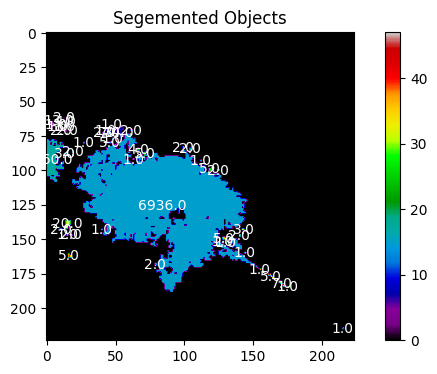

Object 1: Area = 255.0 pixels
Object 2: Area = 1.0 pixels
Object 3: Area = 5796.0 pixels
Object 4: Area = 5.0 pixels
Object 5: Area = 4.0 pixels
Object 6: Area = 579.0 pixels
Object 7: Area = 5.0 pixels
Object 8: Area = 8.0 pixels
Object 9: Area = 1.0 pixels
Object 10: Area = 2.0 pixels
Object 11: Area = 1.0 pixels
Object 12: Area = 1.0 pixels
Object 13: Area = 676.0 pixels


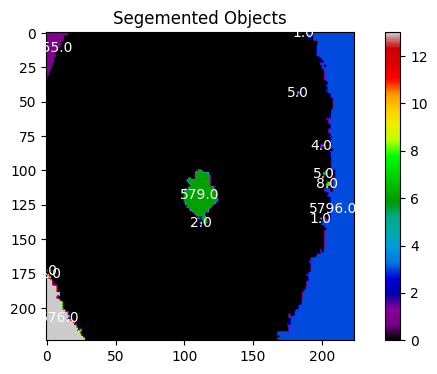

Object 1: Area = 2.0 pixels
Object 2: Area = 1.0 pixels
Object 3: Area = 3.0 pixels
Object 4: Area = 4.0 pixels
Object 5: Area = 5.0 pixels
Object 6: Area = 1.0 pixels
Object 7: Area = 1.0 pixels
Object 8: Area = 2.0 pixels
Object 9: Area = 1.0 pixels
Object 10: Area = 1.0 pixels
Object 11: Area = 2.0 pixels
Object 12: Area = 2.0 pixels
Object 13: Area = 1.0 pixels
Object 14: Area = 1.0 pixels
Object 15: Area = 2.0 pixels
Object 16: Area = 42.0 pixels
Object 17: Area = 2.0 pixels
Object 18: Area = 3.0 pixels
Object 19: Area = 1.0 pixels
Object 20: Area = 10.0 pixels
Object 21: Area = 2.0 pixels
Object 22: Area = 11.0 pixels
Object 23: Area = 16.0 pixels
Object 24: Area = 1.0 pixels
Object 25: Area = 1.0 pixels
Object 26: Area = 6.0 pixels
Object 27: Area = 5.0 pixels
Object 28: Area = 1.0 pixels
Object 29: Area = 1.0 pixels


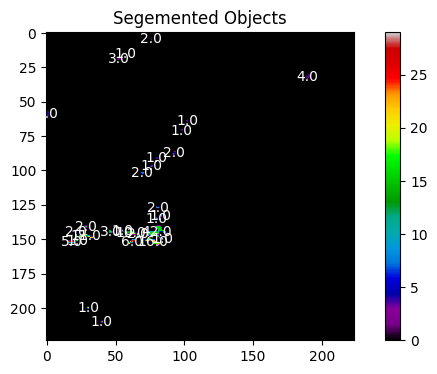

Object 1: Area = 7625.0 pixels
Object 2: Area = 3.0 pixels
Object 3: Area = 1.0 pixels
Object 4: Area = 11.0 pixels
Object 5: Area = 1.0 pixels
Object 6: Area = 2.0 pixels
Object 7: Area = 3.0 pixels
Object 8: Area = 3.0 pixels
Object 9: Area = 1.0 pixels
Object 10: Area = 2.0 pixels
Object 11: Area = 2.0 pixels
Object 12: Area = 7.0 pixels
Object 13: Area = 2.0 pixels
Object 14: Area = 2.0 pixels


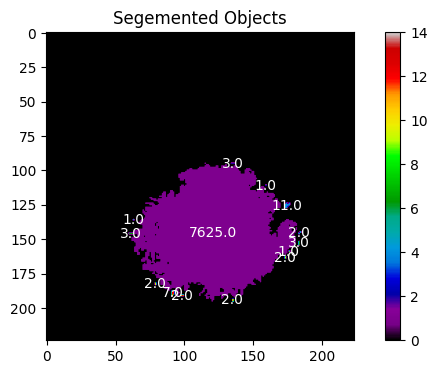

Object 1: Area = 8933.0 pixels
Object 2: Area = 5.0 pixels
Object 3: Area = 3.0 pixels
Object 4: Area = 1.0 pixels
Object 5: Area = 5.0 pixels
Object 6: Area = 1.0 pixels
Object 7: Area = 1.0 pixels
Object 8: Area = 3.0 pixels
Object 9: Area = 2.0 pixels
Object 10: Area = 1.0 pixels
Object 11: Area = 1.0 pixels
Object 12: Area = 1.0 pixels
Object 13: Area = 3.0 pixels
Object 14: Area = 5.0 pixels
Object 15: Area = 1.0 pixels
Object 16: Area = 1.0 pixels
Object 17: Area = 3.0 pixels
Object 18: Area = 4.0 pixels


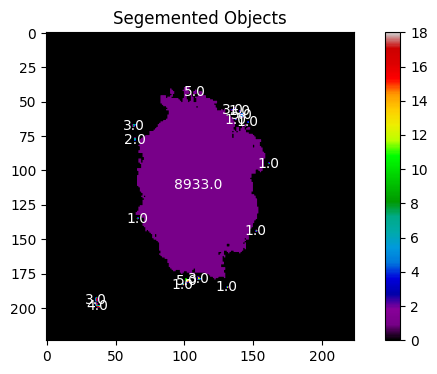

Object 1: Area = 3.0 pixels
Object 2: Area = 1.0 pixels
Object 3: Area = 1272.0 pixels
Object 4: Area = 1.0 pixels
Object 5: Area = 28.0 pixels
Object 6: Area = 3.0 pixels
Object 7: Area = 1.0 pixels
Object 8: Area = 7.0 pixels
Object 9: Area = 4.0 pixels
Object 10: Area = 1.0 pixels


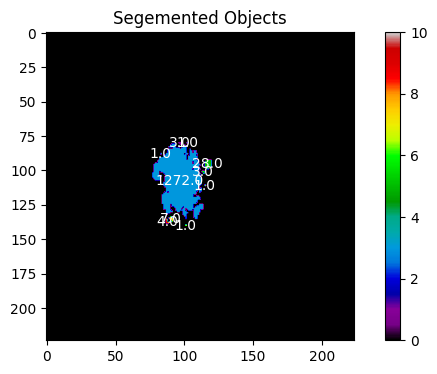

Object 1: Area = 17.0 pixels
Object 2: Area = 1.0 pixels
Object 3: Area = 8198.0 pixels
Object 4: Area = 2.0 pixels
Object 5: Area = 1.0 pixels
Object 6: Area = 3.0 pixels
Object 7: Area = 10.0 pixels
Object 8: Area = 20.0 pixels
Object 9: Area = 1.0 pixels
Object 10: Area = 3.0 pixels
Object 11: Area = 3.0 pixels
Object 12: Area = 1.0 pixels
Object 13: Area = 1.0 pixels
Object 14: Area = 2.0 pixels
Object 15: Area = 1.0 pixels


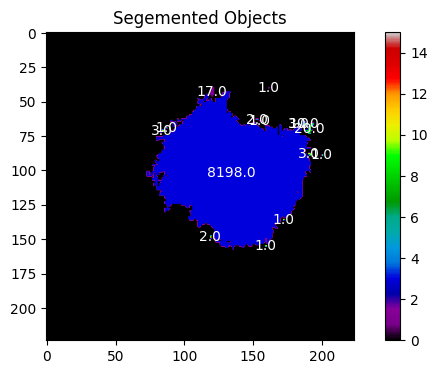

Object 1: Area = 2.0 pixels
Object 2: Area = 3.0 pixels
Object 3: Area = 4379.0 pixels
Object 4: Area = 1.0 pixels
Object 5: Area = 2.0 pixels
Object 6: Area = 3.0 pixels
Object 7: Area = 3.0 pixels
Object 8: Area = 5.0 pixels


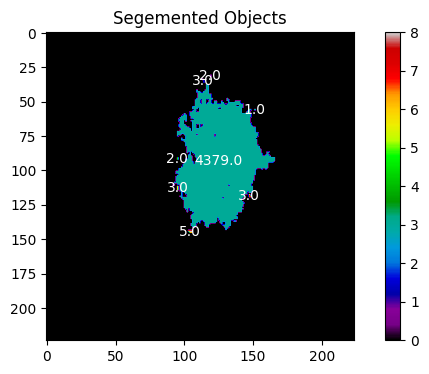

Object 1: Area = 3.0 pixels
Object 2: Area = 2.0 pixels
Object 3: Area = 1.0 pixels
Object 4: Area = 6.0 pixels
Object 5: Area = 8903.0 pixels
Object 6: Area = 1.0 pixels
Object 7: Area = 3.0 pixels
Object 8: Area = 2.0 pixels
Object 9: Area = 1.0 pixels
Object 10: Area = 7.0 pixels
Object 11: Area = 9.0 pixels
Object 12: Area = 1.0 pixels
Object 13: Area = 2.0 pixels
Object 14: Area = 9.0 pixels
Object 15: Area = 2.0 pixels
Object 16: Area = 4.0 pixels
Object 17: Area = 2.0 pixels
Object 18: Area = 1.0 pixels
Object 19: Area = 2.0 pixels
Object 20: Area = 2.0 pixels
Object 21: Area = 1.0 pixels
Object 22: Area = 2.0 pixels
Object 23: Area = 2.0 pixels
Object 24: Area = 2.0 pixels


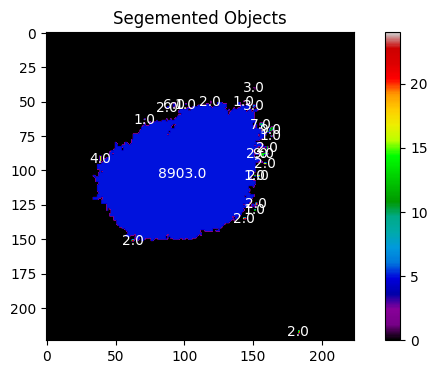

Object 1: Area = 3.0 pixels
Object 2: Area = 14663.0 pixels
Object 3: Area = 6.0 pixels
Object 4: Area = 1.0 pixels
Object 5: Area = 6.0 pixels
Object 6: Area = 4.0 pixels
Object 7: Area = 5.0 pixels
Object 8: Area = 4.0 pixels
Object 9: Area = 1.0 pixels
Object 10: Area = 15.0 pixels
Object 11: Area = 2.0 pixels
Object 12: Area = 4.0 pixels
Object 13: Area = 5.0 pixels
Object 14: Area = 4.0 pixels
Object 15: Area = 2.0 pixels
Object 16: Area = 1.0 pixels
Object 17: Area = 2.0 pixels
Object 18: Area = 5.0 pixels


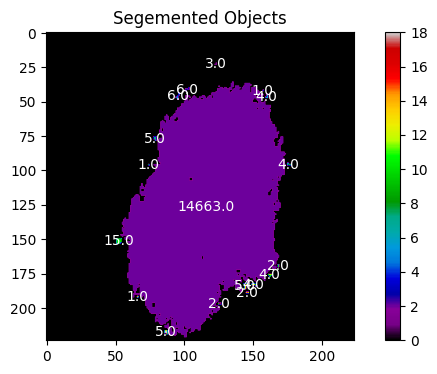

Object 1: Area = 145.0 pixels
Object 2: Area = 1.0 pixels
Object 3: Area = 6.0 pixels
Object 4: Area = 41.0 pixels
Object 5: Area = 225.0 pixels
Object 6: Area = 2.0 pixels
Object 7: Area = 11.0 pixels
Object 8: Area = 22.0 pixels
Object 9: Area = 1.0 pixels
Object 10: Area = 2081.0 pixels
Object 11: Area = 4.0 pixels
Object 12: Area = 6.0 pixels
Object 13: Area = 2.0 pixels
Object 14: Area = 19.0 pixels
Object 15: Area = 2.0 pixels
Object 16: Area = 20.0 pixels
Object 17: Area = 2.0 pixels
Object 18: Area = 13.0 pixels
Object 19: Area = 10.0 pixels
Object 20: Area = 10.0 pixels
Object 21: Area = 1.0 pixels
Object 22: Area = 1.0 pixels
Object 23: Area = 8.0 pixels
Object 24: Area = 1.0 pixels
Object 25: Area = 1.0 pixels
Object 26: Area = 2.0 pixels
Object 27: Area = 5.0 pixels
Object 28: Area = 1.0 pixels
Object 29: Area = 3.0 pixels
Object 30: Area = 1.0 pixels
Object 31: Area = 6.0 pixels


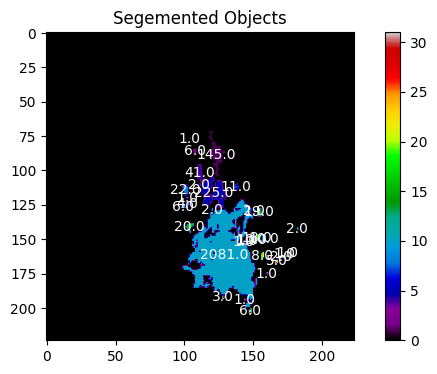

Object 1: Area = 1.0 pixels
Object 2: Area = 1958.0 pixels
Object 3: Area = 15.0 pixels
Object 4: Area = 9.0 pixels
Object 5: Area = 30.0 pixels
Object 6: Area = 1.0 pixels
Object 7: Area = 3.0 pixels
Object 8: Area = 8.0 pixels
Object 9: Area = 7.0 pixels
Object 10: Area = 11.0 pixels
Object 11: Area = 1.0 pixels
Object 12: Area = 2.0 pixels
Object 13: Area = 1.0 pixels
Object 14: Area = 1.0 pixels
Object 15: Area = 2.0 pixels
Object 16: Area = 1.0 pixels
Object 17: Area = 5.0 pixels


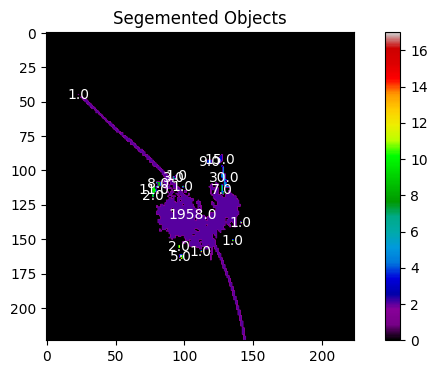

Object 1: Area = 4.0 pixels
Object 2: Area = 10810.0 pixels
Object 3: Area = 23.0 pixels
Object 4: Area = 31.0 pixels
Object 5: Area = 30.0 pixels
Object 6: Area = 3.0 pixels
Object 7: Area = 3.0 pixels
Object 8: Area = 1.0 pixels
Object 9: Area = 4.0 pixels
Object 10: Area = 2.0 pixels
Object 11: Area = 3.0 pixels
Object 12: Area = 1.0 pixels
Object 13: Area = 5.0 pixels
Object 14: Area = 7.0 pixels
Object 15: Area = 36.0 pixels
Object 16: Area = 12.0 pixels
Object 17: Area = 35.0 pixels
Object 18: Area = 58.0 pixels
Object 19: Area = 21.0 pixels
Object 20: Area = 2.0 pixels
Object 21: Area = 8.0 pixels
Object 22: Area = 2.0 pixels
Object 23: Area = 15.0 pixels
Object 24: Area = 2.0 pixels
Object 25: Area = 5.0 pixels
Object 26: Area = 2.0 pixels
Object 27: Area = 70.0 pixels
Object 28: Area = 3.0 pixels
Object 29: Area = 25.0 pixels
Object 30: Area = 1.0 pixels
Object 31: Area = 4.0 pixels
Object 32: Area = 1.0 pixels
Object 33: Area = 1.0 pixels
Object 34: Area = 2.0 pixels
Object 3

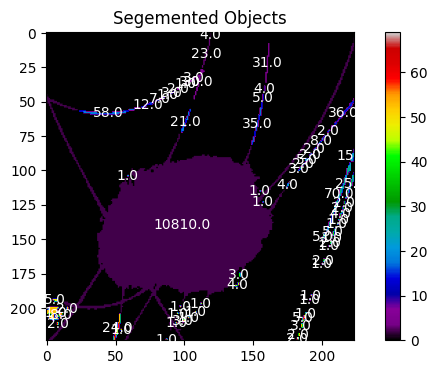

In [106]:
import cv2
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt

def measure_objects(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Apply thresholding to segment objects
    _, binary = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
    
    # Label connected components
    labels = measure.label(binary, connectivity=2, background=0)
    
    # Measure properties of labeled regions
    props = measure.regionprops(labels)
    
    # Visualization
    plt.figure(figsize=(8, 4))
    plt.imshow(labels, cmap='nipy_spectral')
    plt.colorbar()
    plt.title("Segemented Objects")
    
    # Annotate each object with its area
    for i, prop in enumerate(props):
        # Get the coordinates of the centroid of the current object
        y0, x0 = prop.centroid
        # Annotate the object with its area
        plt.text(x0, y0, f"{prop.area}", color="white", fontsize=10, ha='center', va='center')
        
        print(f"Object {i+1}: Area = {prop.area} pixels")

    plt.show()


for i in range(20): 
    image_path = f'./data/train/Benign/{i+1}.jpg' 
    measure_objects(image_path)


# Calculating The Size of Melanoma Spots

In [21]:
def measure_largest_object_area(image):
    _, binary = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
    labels = measure.label(binary, connectivity=2, background=0)
    props = measure.regionprops(labels)
    # Find the largest area
    largest_area = max(prop.area for prop in props) if props else 0
    return largest_area


In [23]:
benign_areas = []
malignant_areas = []

for images, labels in train_loader: 
    images_np = images.numpy()
    images_np = np.transpose(images_np, (0, 2, 3, 1))  # Convert to (N, H, W, C) if necessary

    for i, image_np in enumerate(images_np):
        label = labels[i].item()
        image_gray = rgb2gray(image_np) * 255
        image_gray = image_gray.astype(np.uint8)

        largest_area = measure_largest_object_area(image_gray)

        if label == 0:  # Benign
            benign_areas.append(largest_area)
        else:  # Malignant
            malignant_areas.append(largest_area)


In [108]:
import numpy as np

mean_benign_area = np.mean(benign_areas)
mean_malignant_area = np.mean(malignant_areas)

print(f"Mean Area in Benign Samples in pixels: {mean_benign_area}")
print(f"Mean Area in Malignant Samples in pixels: {mean_malignant_area}")

# Calculate and print the percentage difference
percentage_difference = (abs(mean_benign_area - mean_malignant_area) / ((mean_benign_area + mean_malignant_area) / 2)) * 100
print(f"Percentage Difference between Mean Areas: {percentage_difference:.2f}%")


Mean Area in Benign Samples in pixels: 23888.43112701252
Mean Area in Malignant Samples in pixels: 29787.82146690519
Percentage Difference between Mean Areas: 21.98%


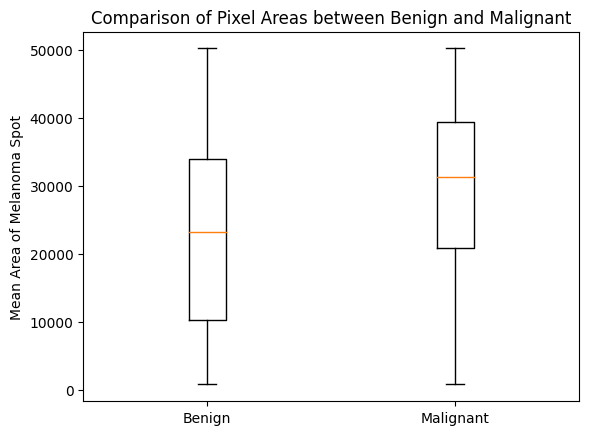

In [110]:
plt.boxplot([benign_areas, malignant_areas], labels=['Benign', 'Malignant'])
plt.ylabel('Mean Area of Melanoma Spot')
plt.title('Comparison of Pixel Areas between Benign and Malignant')
plt.show()


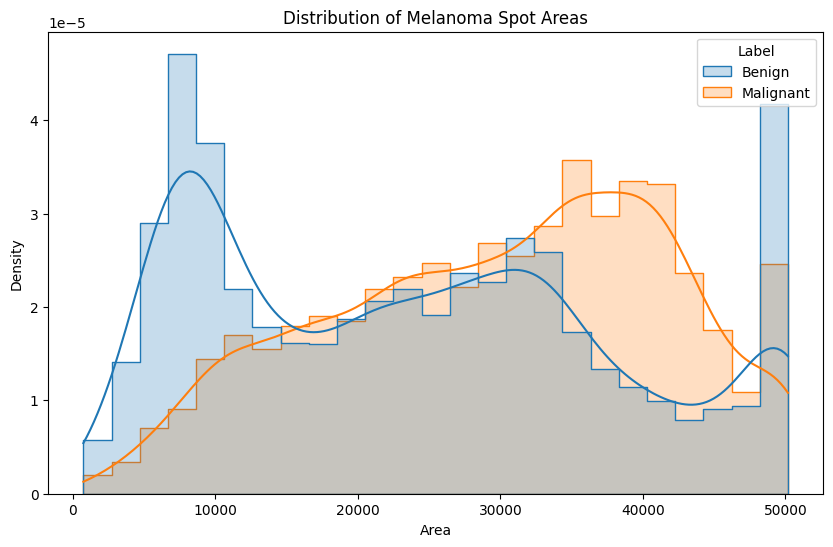

In [105]:
# Combine areas and labels for easier plotting
all_areas = benign_areas + malignant_areas
labels = ['Benign']*len(benign_areas) + ['Malignant']*len(malignant_areas)

# Create a DataFrame for easier plotting
df = pd.DataFrame({'Area': all_areas, 'Label': labels})

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="Area", hue="Label", kde=True, element="step", stat="density", common_norm=False)
plt.title('Distribution of Melanoma Spot Areas')
plt.xlabel('Area')
plt.ylabel('Density')
plt.show()
